In [1]:
Pkg.add("PyPlot")
using PyPlot

INFO: Nothing to be done


In [2]:
function conjugate_gradient(A, x, b, ϵ, itmax)
    r = b - (A * x)
    d = r
    res_cond = ϵ * norm(b)
    rs = [norm(r)]
    for i in 1:itmax
        r_prev = r
        x_prev = x
        Δ_cond = ϵ * norm(x)
        if dot(d, A*d) != 0
            α = dot(d,r) / dot(d, A*d)
        else
            return rs, x
        end
        x = x + α*d
        r = b - (A * x)
        if norm(r) < res_cond && norm(x - x_prev) < Δ_cond
            #println("converged")
            return rs,x
        end
        β = dot(r,r) / dot(r_prev, r_prev)
        d = r + β*d
        push!(rs, norm(r))
    end
    return rs, x
end

conjugate_gradient (generic function with 1 method)

# Let's run an experiment

## Set up a sample of 500 random 150x150 SPD Matrices. We'll run CG on these.

In [3]:
dim = 150
Ms = []
for i in 1:500
    M = 20.*rand(dim,dim)
    #Make this random matrix SPD
    M = .5(M*M')
    push!(Ms, M)
end

### Filter out outlier matrices with absurdly large condition numbers (they make it hard to see trends)

In [4]:
cond_max = 10e8
Ms = filter(M->cond(M) < cond_max, Ms)
@show length(Ms);

length(Ms) = 442


### ...And then verify that all are SPD.

In [5]:
if length(filter(M->isposdef(M) && issymmetric(M), Ms)) == length(Ms)
    println("All matrices SPD")
end

All matrices SPD


#### Setting up variables and empty arrays

In [6]:
x = zeros(dim)
b = collect(1:dim)
k = []
iters1 = []
iters2 = [];

## All right. Here the experiment begins.
This will run CG twice, for _each_ of our sample matrices.

None of these should hit the iteration maximum because of our condition number pruning.

The difference between the runs is in the tolerances. The second run has an extra sig fig in the tolerance.

We'll save the number of iterations here so we can see how CG is doing.

In [7]:
for M in Ms
    res1, _ = conjugate_gradient(M, x, b, 1e-5 , 10000)
    res2, _ = conjugate_gradient(M, x, b, 1e-6, 10000)
    push!(k, cond(M))
    push!(iters1, length(res1)-1)
    push!(iters2, length(res2)-1)
end

## Looking at the Data

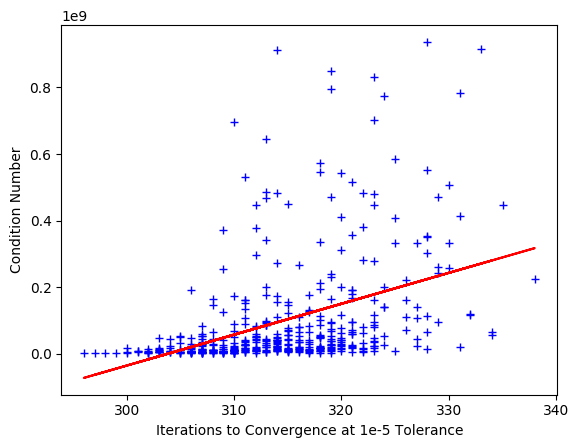

In [8]:
plot(iters1, k, "b+")
ylabel("Condition Number")
xlabel("Iterations to Convergence at 1e-5 Tolerance")
a, b = linreg(iters1, k)
plot(iters1, a + b*iters1, "r");

### Here we examine only the data from CG with 1e-5 convergence tolerance.
Looking at the number of iterations plotted against the condition number, it is easy to see a clear trend -- an increase in iterations for performing CG on a matrix with a higher condition number. 

While the regression performed here is only linear, this trend should theoretically have a quadratic $O(n^2)$ relationship.

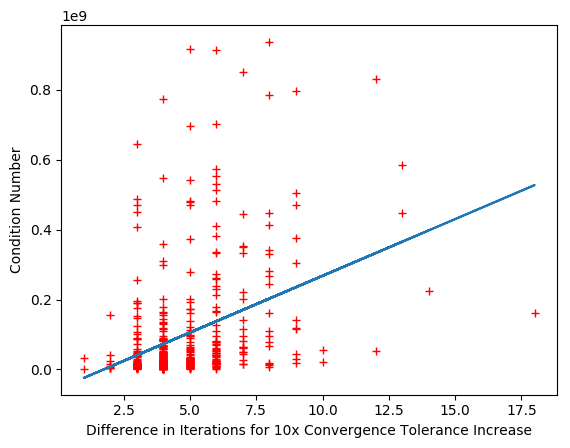

In [9]:
sig_diff = iters2 - iters1
plot(sig_diff, k, "r+")
ylabel("Condition Number")
xlabel("Difference in Iterations for 10x Convergence Tolerance Increase")
a, b = linreg(sig_diff, k)
plot(sig_diff, a + b*sig_diff);

# Gram-Schmidt

In [10]:
function gram_schmidt(basis)
    n = length(basis)
    #this sets ortho[1] = basis[1] as well as sets ortho's dimensions correctly
    ortho = deepcopy(basis)  
    for j in 2:n
        a = zeros(j-1)
        for i in 1:j-1
            a[i] = dot(basis[j], ortho[i]) / dot(ortho[i], ortho[i])
        end
        ortho[j] = basis[j] - sum([a[i]*ortho[i] for i in 1:j-1])
    end
    return ortho
end;

### Random non-orthogonal basis to "seed" Gram-Schmidt
The non-zero array is proof that the vectors aren't orthogonal to one another

In [11]:
basis = [rand(4) for i in 1:4]
display(basis)
print([dot(v, w) > eps() ? dot(v,w) : 0 for v in basis for w in basis if v != w])       

4-element Array{Array{Float64,1},1}:
 [0.0608121,0.484729,0.414814,0.219375] 
 [0.235343,0.111583,0.472378,0.770868]  
 [0.718666,0.00210028,0.649049,0.843008]
 [0.419709,0.538164,0.856795,0.113642]  

[0.433458,0.498891,0.666728,0.433458,1.12581,0.65116,0.498891,1.12581,0.954664,0.666728,0.65116,0.954664]

### And now orthogonalize the basis with Gram-Schmidt
The same calculation is done as before to produce the (now all zero) array of dot products

In [12]:
ortho = gram_schmidt(basis)
display(ortho)
print([dot(v, w) > eps() ? dot(v,w) : 0 for v in ortho for w in ortho if v != w])

4-element Array{Array{Float64,1},1}:
 [0.0608121,0.484729,0.414814,0.219375]   
 [0.177897,-0.346315,0.0805248,0.563636]  
 [0.407797,-0.0484631,0.0872574,-0.170954]
 [-0.074352,-0.10336,0.165349,-0.0636631] 

[0,0,0,0,0,0,0,0,0,0,0,0]

# Orthogonalization of Moments

In [13]:
function ortho_moments(basis, A)
    n = length(basis)
    ortho = deepcopy(basis)
    for j in 1:n-1
        a = dot(ortho[j], A*A*ortho[j]) / dot(ortho[j], A*ortho[j])
        if j == 1
            ortho[2] = A*ortho[1] - α*ortho[1]
        else
            b = dot(ortho[j-1], A*A*ortho[j]) / dot(ortho[j-1], A*ortho[j-1])
            ortho[j+1] = A*ortho[j] - a*ortho[j] - b*ortho[j-1]
        end
    end
    return ortho
end;    

In [14]:
M = 2.*rand(4,4)
#Make this random matrix SPD
M = .5(M*M')

4×4 Array{Float64,2}:
 3.27258  2.39866  3.56423  3.1777 
 2.39866  3.10967  2.85869  2.4188 
 3.56423  2.85869  4.18123  3.81767
 3.1777   2.4188   3.81767  3.60735

In [19]:
ortho = ortho_moments(basis, M)
display(ortho)
print([dot(v, M*w) > 200*eps() ? dot(v, M*w) : 0 for v in ortho for w in ortho if v != w])

4-element Array{Array{Float64,1},1}:
 [0.0608121,0.484729,0.414814,0.219375]  
 [2.77334,-2.71993,-1.03689,0.984701]    
 [-1.66636,-0.317484,1.68427,-0.0177854] 
 [0.0853723,0.0474151,-0.334533,0.249874]

[0,0,0,0,0,0,0,0,0,0,0,0]